In [1]:
cd ..

/mnt/c/Users/macle/Dropbox/mcode/SerpentAI


In [214]:
from plugins.SerpentMiniMetroGamePlugin.files.api.object_detector.pytorch_detector import PytorchObjectDetector
from plugins.SerpentMiniMetroGamePlugin.files.api.object_detector.utils import rgb2gray3d
from ptyolov3.utils.datasets import ListDataset

import torch
from skimage.io import imread

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from itertools import islice, zip_longest
from pathlib import Path
from line_profiler import LineProfiler
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
model_path = 'ml_train/station_detector/pytorch/models/m1/checkpoints/station_detector_pt_yolov3_m1_cpkt_15.pth'
config_path = 'ml_train/station_detector/pytorch/models/m1/yolov3-custom.cfg'
labels_path = None
img_size = 416
conf_threshold = 0.5
nms_threshold = 0.1

In [4]:
station_detector = PytorchObjectDetector(model_path, config_path, labels_path, img_size)

In [185]:
img_paths = [
    Path('ml_train/station_detector/pytorch/data/images/frame_1534972093.4974935.png'),
    Path('ml_train/station_detector/pytorch/data/images/frame_1534972209.5071604.png')
]

img_filenames = [img_path.name for img_path in img_paths]

images = [imread(img_path) for img_path in img_paths]

In [6]:
%%time
detection_results = [station_detector.predict(image, conf_threshold, nms_threshold) for image in images] 

CPU times: user 7.66 s, sys: 672 ms, total: 8.33 s
Wall time: 4.23 s


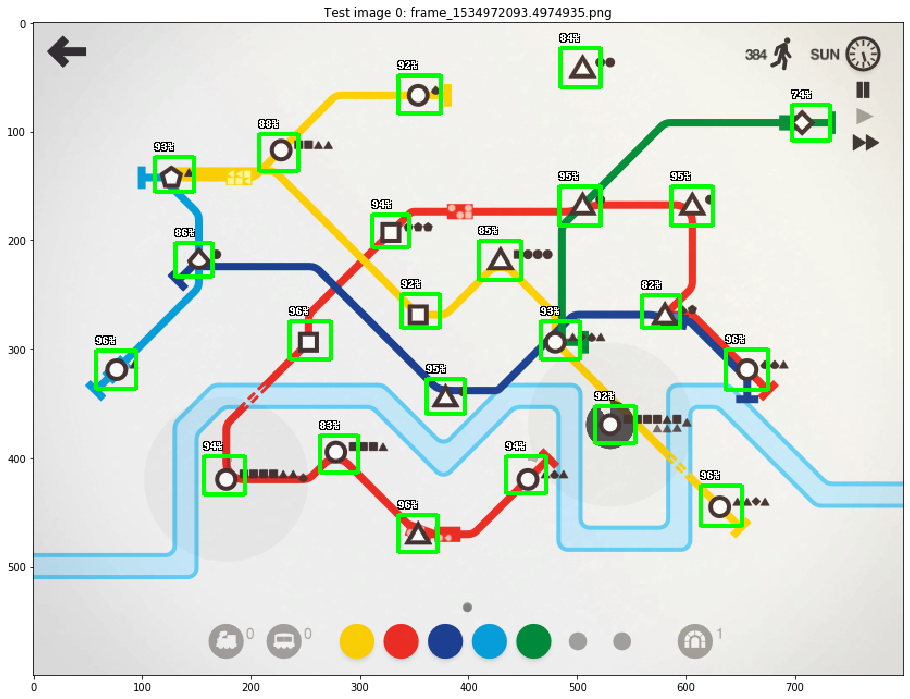

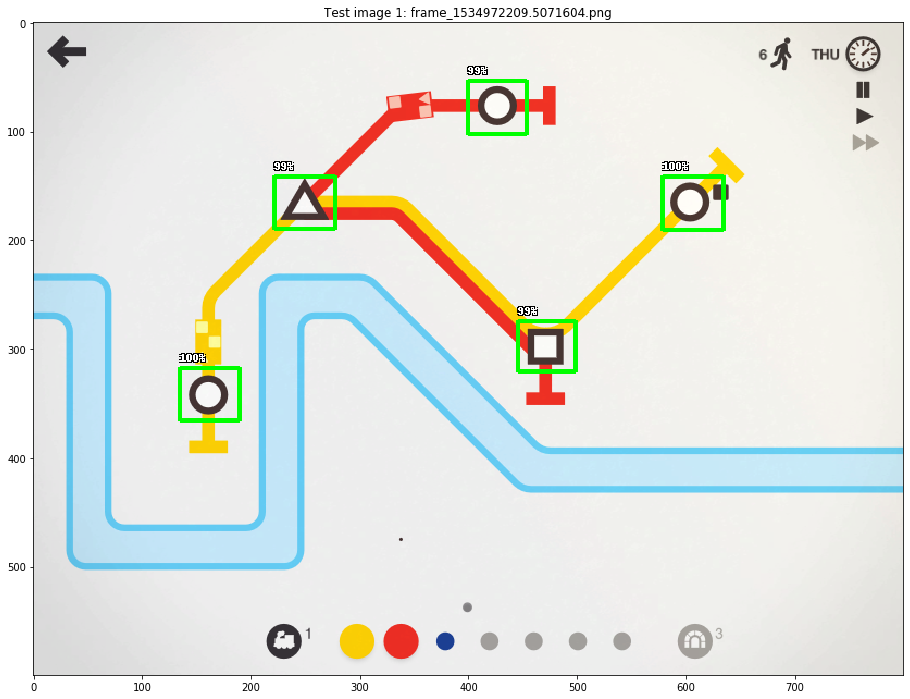

In [7]:
for i, (image, img_filename, detection_result) in enumerate(zip(images, img_filenames, detection_results)):
    _, ax = plt.subplots(figsize=(22,12))
    image_box = station_detector.draw_bounding_boxes(image, **detection_result) 
    ax.set_title(f"Test image {i}: {img_filename}")
    ax.imshow(image_box);

In [8]:
lp = LineProfiler()
lp.add_function(station_detector.model.forward)   # add additional function to profile
lp_wrapper = lp(station_detector.predict)
lp_wrapper(images[0], conf_threshold, nms_threshold)
lp.print_stats()

Timer unit: 1e-06 s

Total time: 1.99194 s
File: /mnt/c/Users/macle/Dropbox/mcode/PyTorch-YOLOv3/ptyolov3/models.py
Function: forward at line 246

Line #      Hits         Time  Per Hit   % Time  Line Contents
   246                                               def forward(self, x, targets=None):
   247         1         32.0     32.0      0.0          img_dim = x.shape[2]
   248         1         16.0     16.0      0.0          loss = 0
   249         1         18.0     18.0      0.0          layer_outputs, yolo_outputs = [], []
   250       108        702.0      6.5      0.0          for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
   251       107        446.0      4.2      0.0              if module_def["type"] in ["convolutional", "upsample", "maxpool"]:
   252        77    1965575.0  25526.9     98.7                  x = module(x)
   253        30        102.0      3.4      0.0              elif module_def["type"] == "route":
   254         4   

Majority of time is spent on convolutional, upsampling and maxpool layers, it is unlikely that reducing the number of feature map (scales) in the head that yolo predicts on will radically affect inference time, but will investigate which feature maps / detectors are being utilised regardless

In [9]:
output_layers = station_detector.model.yolo_layers

output_layers

[YOLOLayer(
   (mse_loss): MSELoss()
   (bce_loss): BCELoss()
 ), YOLOLayer(
   (mse_loss): MSELoss()
   (bce_loss): BCELoss()
 ), YOLOLayer(
   (mse_loss): MSELoss()
   (bce_loss): BCELoss()
 )]

In [10]:
layer_dict = {}

Creating hooks to return the activations of the final layers in the model for inspections

In [11]:
def inspect_layer(self, input, output):
    global layer_dict
    layer_dict[self] = (input, output)

In [12]:
handles = [layer.register_forward_hook(inspect_layer) for layer in output_layers]

In [13]:
handles

In [14]:
station_detector.predict(images[1], conf_threshold, nms_threshold)

{'boxes': [{'xmin': 0.72413945,
   'ymin': 0.2354737,
   'xmax': 0.7932568,
   'ymax': 0.31891915},
  {'xmin': 0.169619, 'ymin': 0.52895945, 'xmax': 0.23634595, 'ymax': 0.610185},
  {'xmin': 0.27812433,
   'ymin': 0.23530564,
   'xmax': 0.34738195,
   'ymax': 0.31753588},
  {'xmin': 0.55810297,
   'ymin': 0.4566714,
   'xmax': 0.6230367,
   'ymax': 0.5350702},
  {'xmin': 0.5007768,
   'ymin': 0.08930788,
   'xmax': 0.5668403,
   'ymax': 0.17274465}],
 'object_conf': array([0.9972257 , 0.99669063, 0.99171805, 0.9883858 , 0.98723906],
       dtype=float32),
 'scores': array([0.9999137 , 0.99987555, 0.9997621 , 0.999694  , 0.9998348 ],
       dtype=float32),
 'category_ids': array([0, 0, 0, 0, 0], dtype=uint8)}

In [15]:
def grid_plot(tensor, ncols, figsize=None, vmin=None, vmax=None):
    
    c, w, h = tensor.shape
    
    nrows = int(np.ceil(c / ncols))
    ncols = int(ncols)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    for channel, ax in zip_longest(tensor, axes.flat):
        
        if channel is not None:
            ax.imshow(channel.numpy(), cmap='gray', vmin=vmin, vmax=vmax)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        else:
            fig.delaxes(ax)
            
    return fig

Visualising the activations from the final convolutional layer for each of the three scales in the yolo head, this is the raw output of the model

YOLOLayer(
  (mse_loss): MSELoss()
  (bce_loss): BCELoss()
)
Anchors: [(70, 70), (80, 80), (90, 90)]
torch.Size([1, 18, 13, 13])


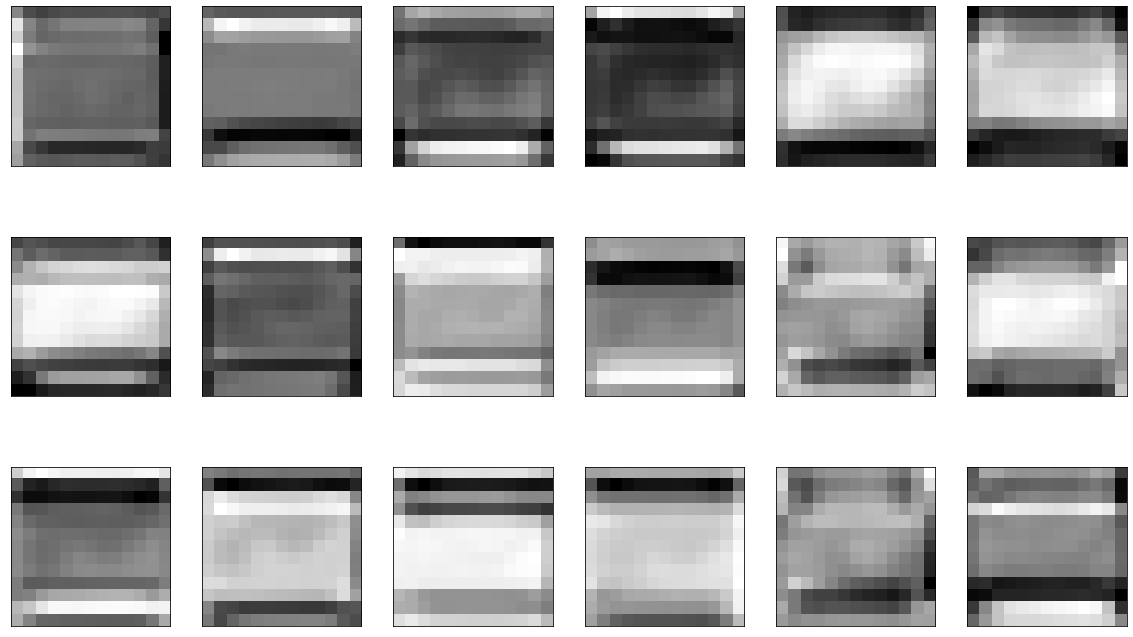

YOLOLayer(
  (mse_loss): MSELoss()
  (bce_loss): BCELoss()
)
Anchors: [(40, 40), (50, 50), (60, 60)]
torch.Size([1, 18, 26, 26])


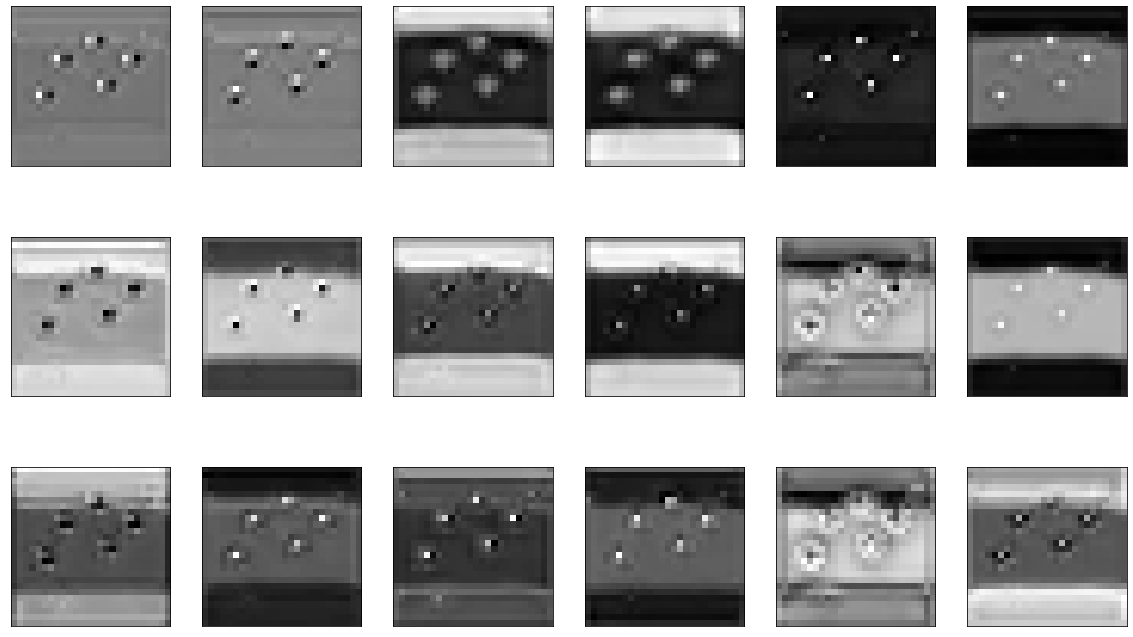

YOLOLayer(
  (mse_loss): MSELoss()
  (bce_loss): BCELoss()
)
Anchors: [(10, 10), (20, 20), (30, 30)]
torch.Size([1, 18, 52, 52])


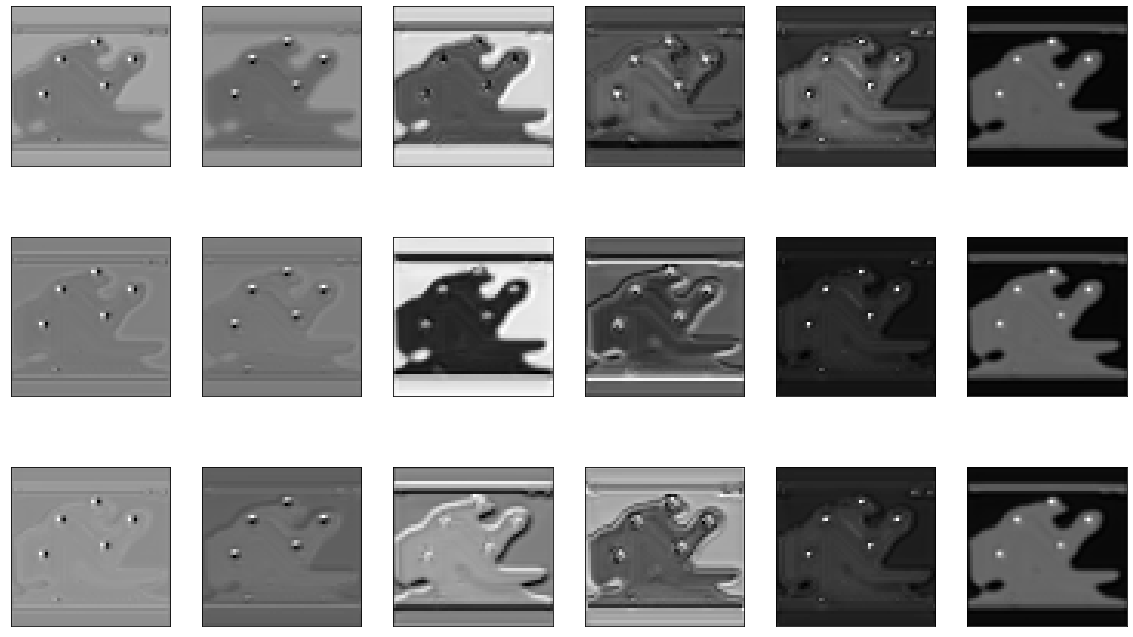

In [16]:
for layer in output_layers:
    print(layer)
    print('Anchors:', layer.anchors)
    l_i, l_o = layer_dict[layer]
    print(l_i[0].shape)
    fig = fig = grid_plot(l_i[0].squeeze(), ncols=6, figsize=(20,12))
    plt.show();

The columns 1,2 shows the box x/y midpoints, columns 3,4 shows the box width/height scalars, column 5 shows the object confidence scores and column 6 contains the (single) class probability. Each row represents a different detector (different anchor box)

Will now focus on column 5, the object confidence scores, this time passing the logits through a sigmoid activation and scaling the plot between [0,1]

YOLOLayer(
  (mse_loss): MSELoss()
  (bce_loss): BCELoss()
)
Anchors: [(70, 70), (80, 80), (90, 90)]
torch.Size([1, 18, 13, 13])


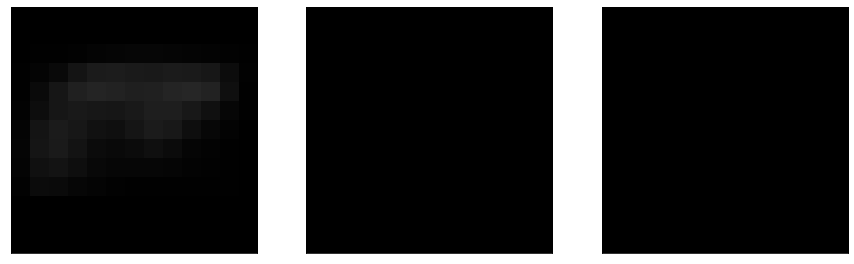

YOLOLayer(
  (mse_loss): MSELoss()
  (bce_loss): BCELoss()
)
Anchors: [(40, 40), (50, 50), (60, 60)]
torch.Size([1, 18, 26, 26])


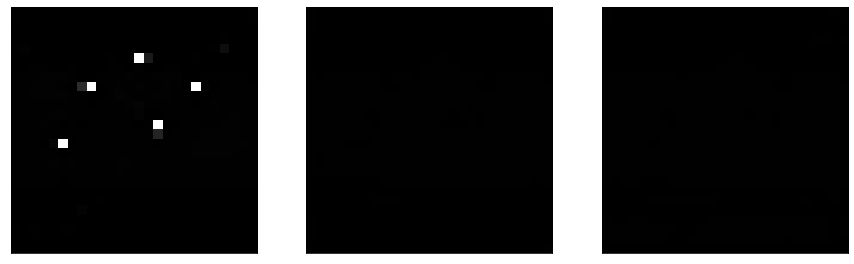

YOLOLayer(
  (mse_loss): MSELoss()
  (bce_loss): BCELoss()
)
Anchors: [(10, 10), (20, 20), (30, 30)]
torch.Size([1, 18, 52, 52])


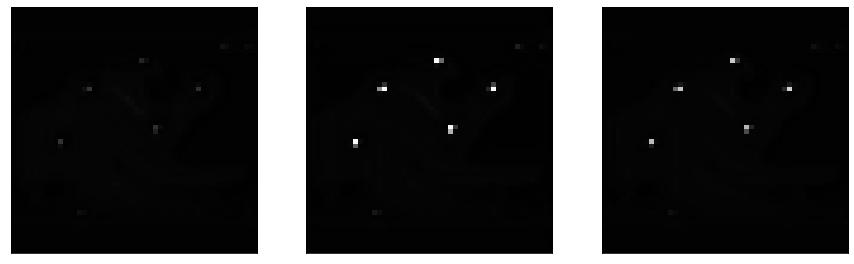

In [17]:
for layer in output_layers:
    print(layer)
    print('Anchors:', layer.anchors)
    l_i, l_o = layer_dict[layer]
    print(l_i[0].shape)
    object_conf_activations = l_i[0].squeeze()[(4,10,16), ...]
    probs = torch.sigmoid(object_conf_activations)
    fig = fig = grid_plot(probs, ncols=3, figsize=(15,10), vmin=0, vmax=1)
    plt.show();

Now repeating with the first image which has more predictions with smaller boxes

In [19]:
station_detector.predict(images[0], conf_threshold, nms_threshold)

{'boxes': [{'xmin': 0.07280793,
   'ymin': 0.50271183,
   'xmax': 0.11774288,
   'ymax': 0.56184536},
  {'xmin': 0.7677928,
   'ymin': 0.7094186,
   'xmax': 0.81492007,
   'ymax': 0.77216977},
  {'xmin': 0.79687715,
   'ymin': 0.5007668,
   'xmax': 0.8444214,
   'ymax': 0.5644542},
  {'xmin': 0.42107737,
   'ymin': 0.75492877,
   'xmax': 0.4649561,
   'ymax': 0.812908},
  {'xmin': 0.29535493,
   'ymin': 0.45707142,
   'xmax': 0.34214652,
   'ymax': 0.51706517},
  {'xmin': 0.45251682,
   'ymin': 0.5465697,
   'xmax': 0.49617004,
   'ymax': 0.6010452},
  {'xmin': 0.73468053,
   'ymin': 0.25054815,
   'xmax': 0.7807235,
   'ymax': 0.3119541},
  {'xmin': 0.6051599,
   'ymin': 0.25063536,
   'xmax': 0.65128154,
   'ymax': 0.31268343},
  {'xmin': 0.54411864,
   'ymin': 0.66412646,
   'xmax': 0.5888808,
   'ymax': 0.72201335},
  {'xmin': 0.3902952,
   'ymin': 0.29362038,
   'xmax': 0.43228576,
   'ymax': 0.34665373},
  {'xmin': 0.19685124,
   'ymin': 0.6637262,
   'xmax': 0.2436966,
   'ymax'

YOLOLayer(
  (mse_loss): MSELoss()
  (bce_loss): BCELoss()
)
Anchors: [(70, 70), (80, 80), (90, 90)]
torch.Size([1, 18, 13, 13])


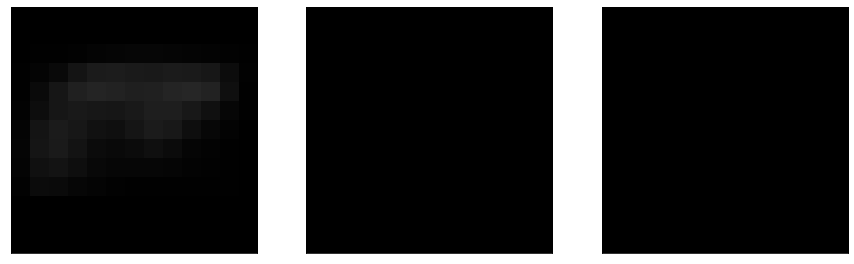

YOLOLayer(
  (mse_loss): MSELoss()
  (bce_loss): BCELoss()
)
Anchors: [(40, 40), (50, 50), (60, 60)]
torch.Size([1, 18, 26, 26])


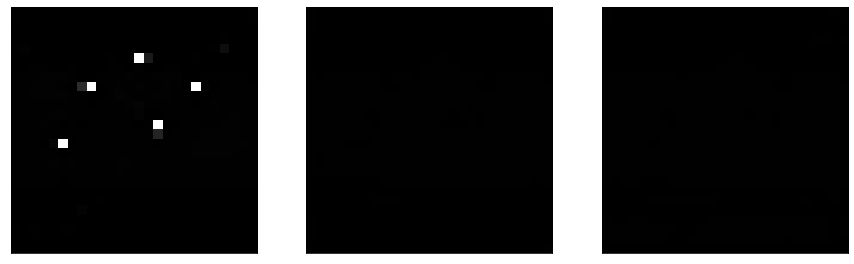

YOLOLayer(
  (mse_loss): MSELoss()
  (bce_loss): BCELoss()
)
Anchors: [(10, 10), (20, 20), (30, 30)]
torch.Size([1, 18, 52, 52])


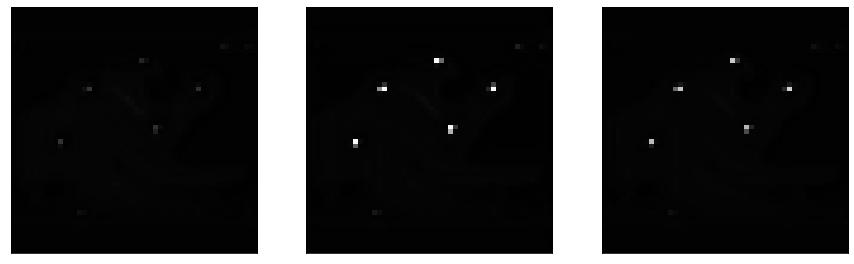

In [59]:
for layer in output_layers:
    print(layer)
    print('Anchors:', layer.anchors)
    l_i, l_o = layer_dict[layer]
    print(l_i[0].shape)
    object_conf_activations = l_i[0].squeeze()[(4,10,16), ...]
    probs = torch.sigmoid(object_conf_activations)
    fig = fig = grid_plot(probs, ncols=3, figsize=(15,10), vmin=0, vmax=1)
    plt.show();

In both cases only the detectors which have smaller anchors boxes, and are applied to the higher resolution feature map are being utilised. Possible reasons for the lack of predictions in the lower resolution feature map:
* The receptive field reference by each cell is too wide and contains multiple target objects
* The anchor boxes are too large and it is easier for the model to adapt the boxes which are closer to the actual target size
* The anchor boxes are too large and are never matched as targets due to the higher IOU index of the smaller anchor boxes

Now visualising actual image with object confidence and predicted boxes overlaid. Using image with larger boxes for clarity

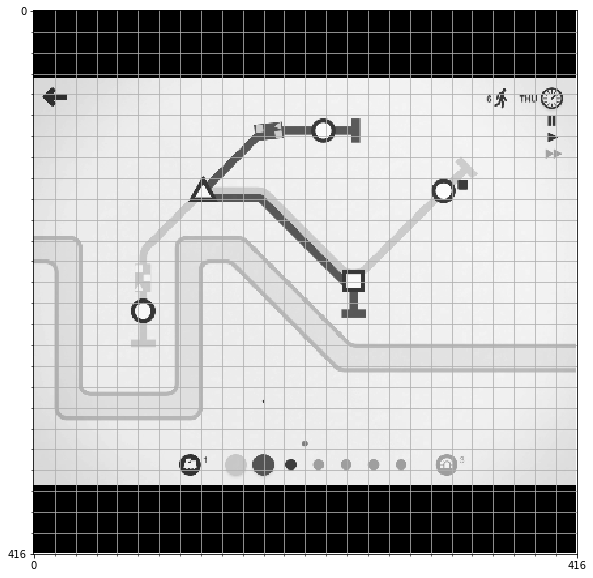

In [155]:
fig = annotate_image(input_image_array, grid_size=26)

In [192]:
Path('tmp.txt').write_text(str(img_paths[1]))

dataset = ListDataset('tmp.txt', img_size=img_size, augment=False, multiscale=False)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, collate_fn=dataset.collate_fn)

In [198]:
img_path, test_image, test_targets = next(iter(dataloader))

In [199]:
test_image_array = test_image.squeeze().permute(1,2,0).numpy()

test_image_array = rgb2gray3d(input_image_array)

Converting image to grayscale to make visualisation clearer

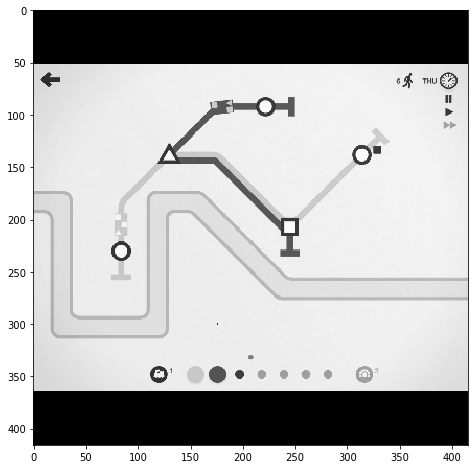

In [200]:
_, ax = plt.subplots(figsize=(8,8))
ax.imshow(test_image_array)

In [402]:
def annotate_image(input_image_array, targets, anchor_wh, grid_size, object_conf_grid=None, figsize=(12,12)):
    
    w, h, c = input_image_array.shape
    
    fig, ax = plt.subplots(figsize=figsize)
        
    # plot image
    input_image_array = rgb2gray3d(input_image_array)
    ax.imshow(input_image_array)
    
    # plot feature map grid for target layer
    ax.set_xticks([0,w])
    ax.set_yticks([0,w])
    ax.set_xticks(np.linspace(0, w, grid_size+1).astype(int), minor=True)
    ax.set_yticks(np.linspace(0, w, grid_size+1).astype(int), minor=True)
    ax.grid(True, which='minor', axis='both', alpha=0.6)
    
    # add target bounding boxes
    boxes = targets[:, 2:] * w
    
    for target_xmid, target_ymid, target_w, target_h in boxes:
        target_xmin = target_xmid - (target_w * 0.5)
        target_ymin = target_ymid - (target_h * 0.5)
        
        box_patch = patches.Rectangle((target_xmin, target_ymin), target_w, target_h, linewidth=3, edgecolor='blue', facecolor="none")
        
        ax.add_patch(box_patch)
        
    # add anchors
    grid_cell_size = w / grid_size
    
    anchor_xy_mids = np.linspace(0 + (grid_cell_size / 2), w - (grid_cell_size / 2), grid_size)
    
    anchor_w, anchor_h = anchor_wh
    
    midcell = grid_size // 2
    
    # only plotting a single example anchor in them middle of the plot to avoid busy overlapping (can easily extend this)
    anchor_xmid, anchor_ymid = anchor_xy_mids[midcell], anchor_xy_mids[midcell]
    anchor_xmin = anchor_xmid - (anchor_w * 0.5)
    anchor_ymin = anchor_ymid - (anchor_h * 0.5)

    box_patch = patches.Rectangle((anchor_xmin, anchor_ymin), anchor_w, anchor_h, linewidth=2, edgecolor='green', facecolor="none")
    ax.add_patch(box_patch)
    
    # plot predictions
    if object_conf_grid is not None:
        upsampled_grid = (torch.nn.functional.interpolate(object_conf_grid[None, None, ...], size=img_size)
                                                         .squeeze()
                                                         .numpy())
        ax.imshow(upsampled_grid, cmap='Reds', alpha=0.7, vmin=0, vmax=0.8)
    
    
    return fig

In [403]:
yolo_o_1, yolo_o_2, yolo_o_3 = output_layers

Overlaying object confidence on raw image, each plot corresponds to a single anchor size (single detector)
* gridlines show the division of each cell in the final feature map
* blue boxes show ground truth target boxes
* red highlighting shows object confidence corresponding to grid cell
* green boxes show a single example of an anchor box for the given anchor size

YOLOLayer(
  (mse_loss): MSELoss()
  (bce_loss): BCELoss()
)
torch.Size([3, 13, 13])
(70, 70)


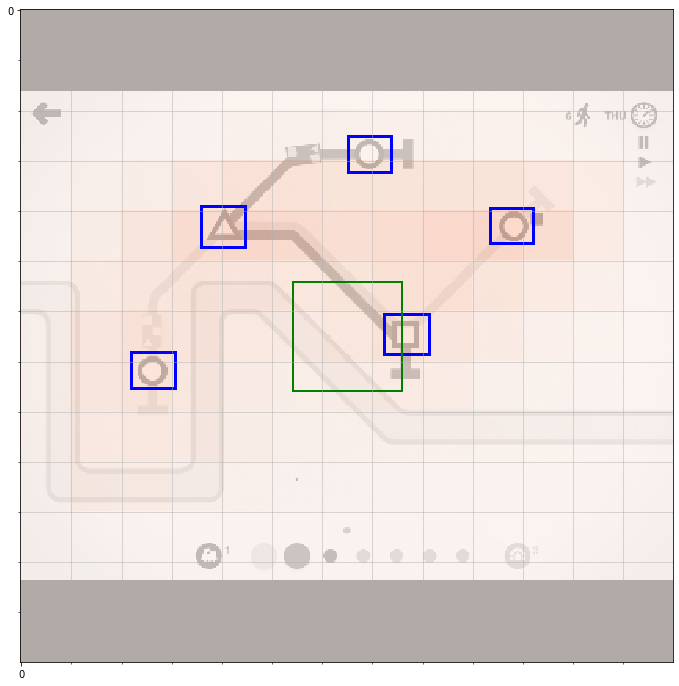

(80, 80)


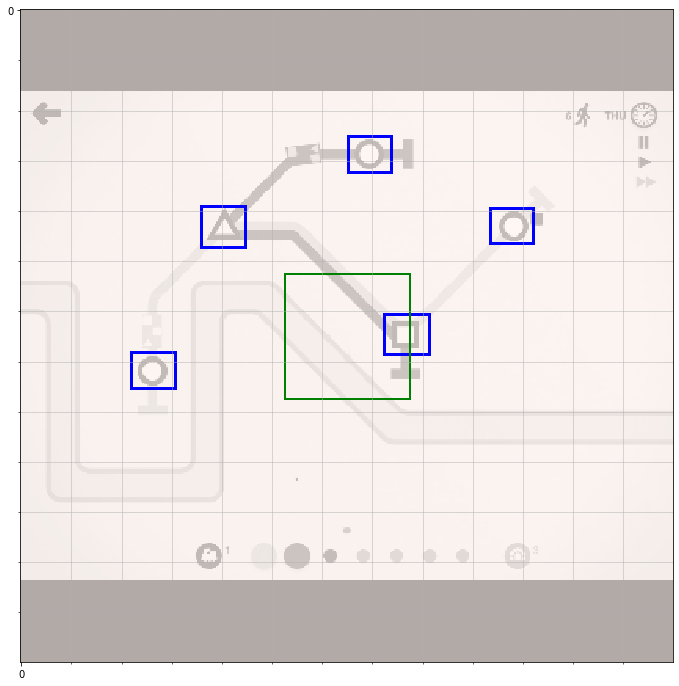

(90, 90)


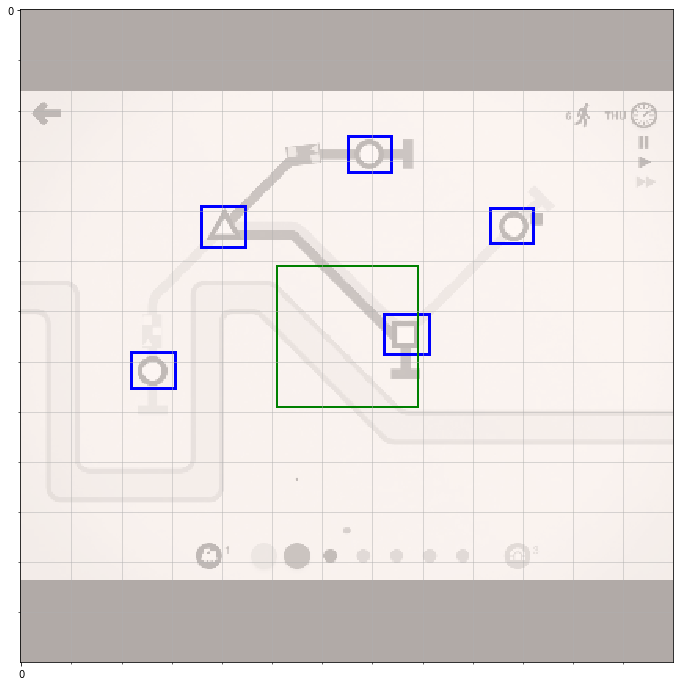

YOLOLayer(
  (mse_loss): MSELoss()
  (bce_loss): BCELoss()
)
torch.Size([3, 26, 26])
(40, 40)


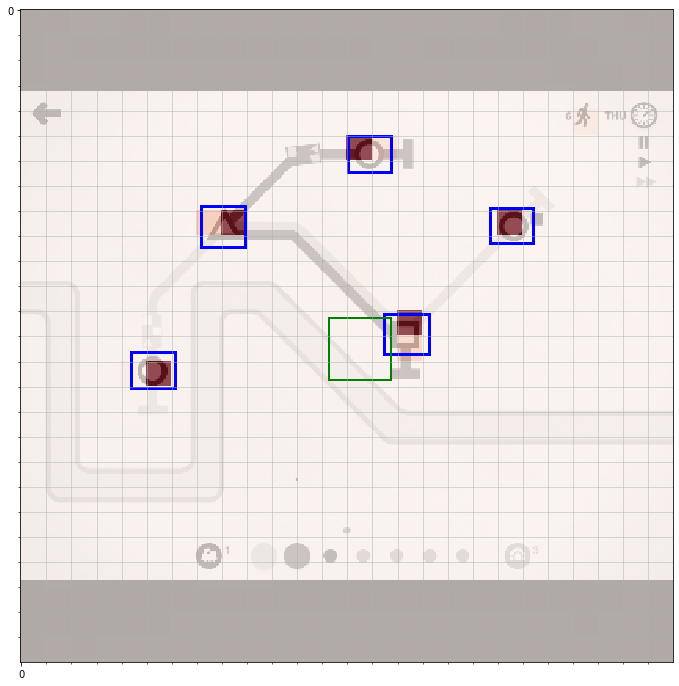

(50, 50)


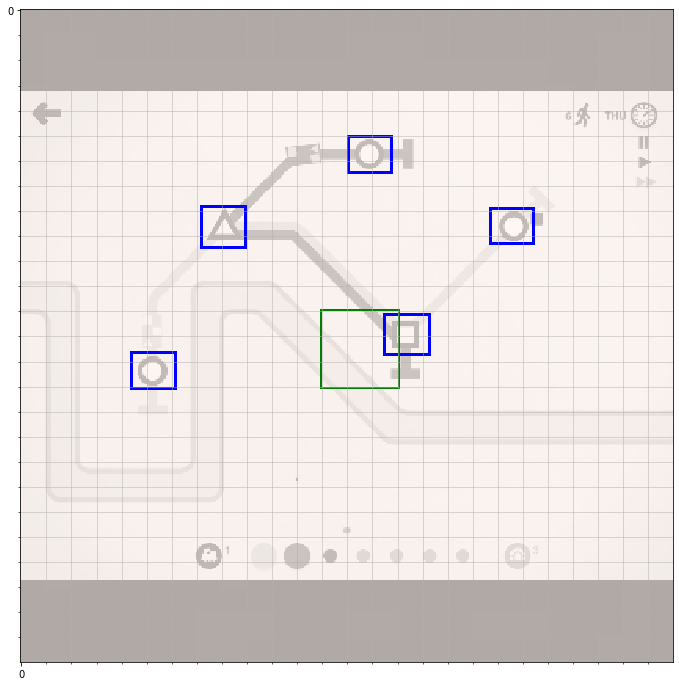

(60, 60)


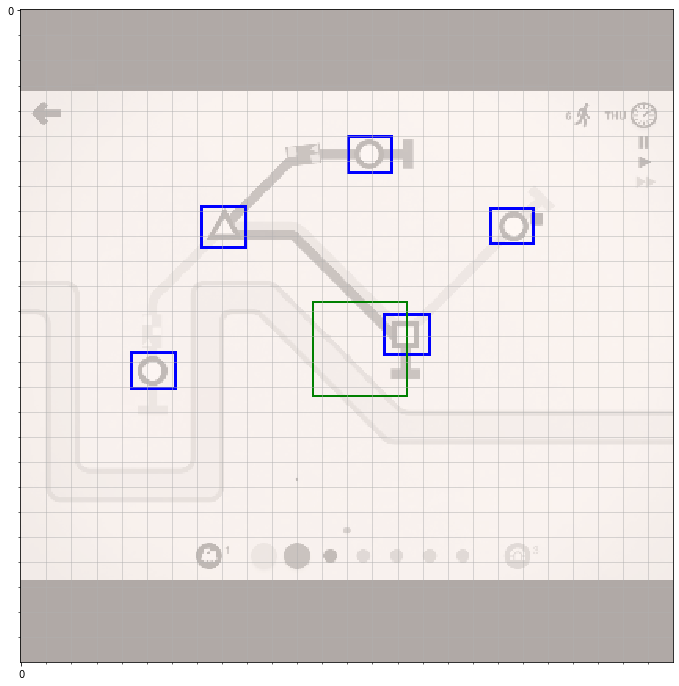

YOLOLayer(
  (mse_loss): MSELoss()
  (bce_loss): BCELoss()
)
torch.Size([3, 52, 52])
(10, 10)


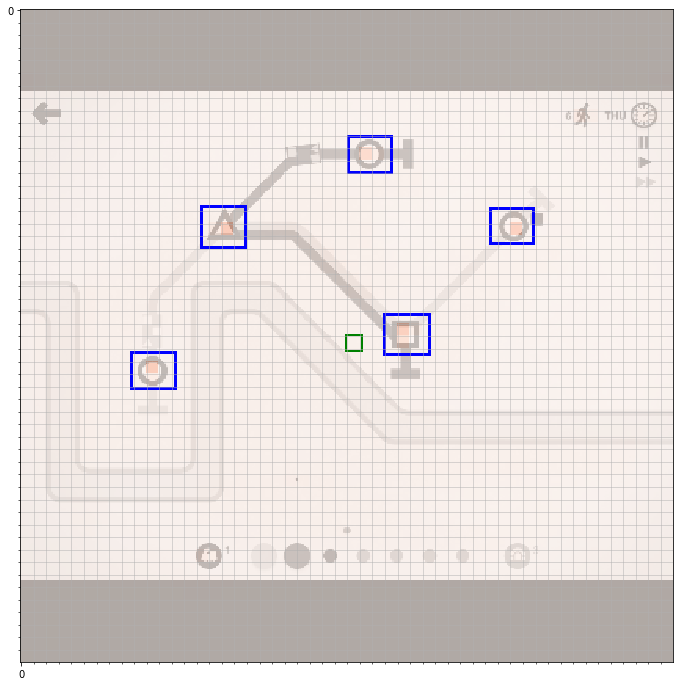

(20, 20)


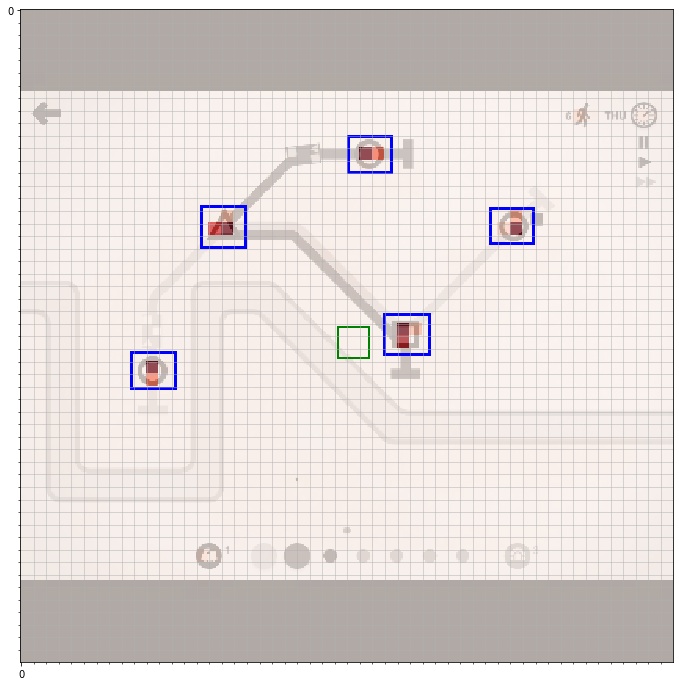

(30, 30)


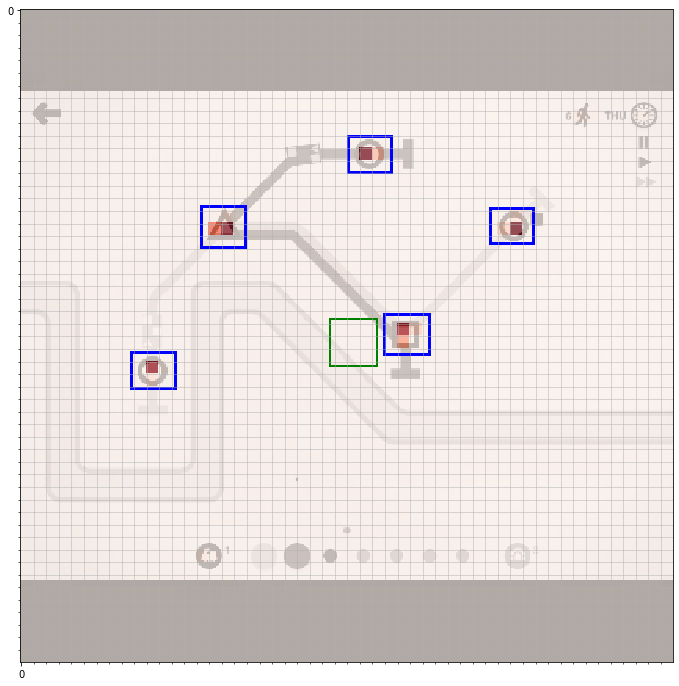

In [405]:
for layer in output_layers:
    print(layer)
    
    l_i, l_o = layer_dict[layer]
    
    object_conf_activations = l_i[0].squeeze()[(4,10,16), ...]
    probs = torch.sigmoid(object_conf_activations)
    print(probs.shape)
    for anchor, detector_probs in zip(layer.anchors, probs):
        print(anchor)
        
        fig = annotate_image(
            test_image_array,
            test_targets,
            anchor_wh=anchor,
            object_conf_grid=detector_probs,
            grid_size=layer.grid_size
        );
        plt.show();

It is not clear whether the redundancy of low resolution features maps is due to the large receptive field, or that they have been paired with larger anchors. An interesting further test would be to fix the anchor size and/or remove feature maps of a given resolution to see how the performance is affected.

In summary it appears that using only 1 or 2 anchors on a single feature map could achieve good performance given the specific nature of the task.

Re-running plots for second test image

YOLOLayer(
  (mse_loss): MSELoss()
  (bce_loss): BCELoss()
)
torch.Size([3, 13, 13])
(70, 70)


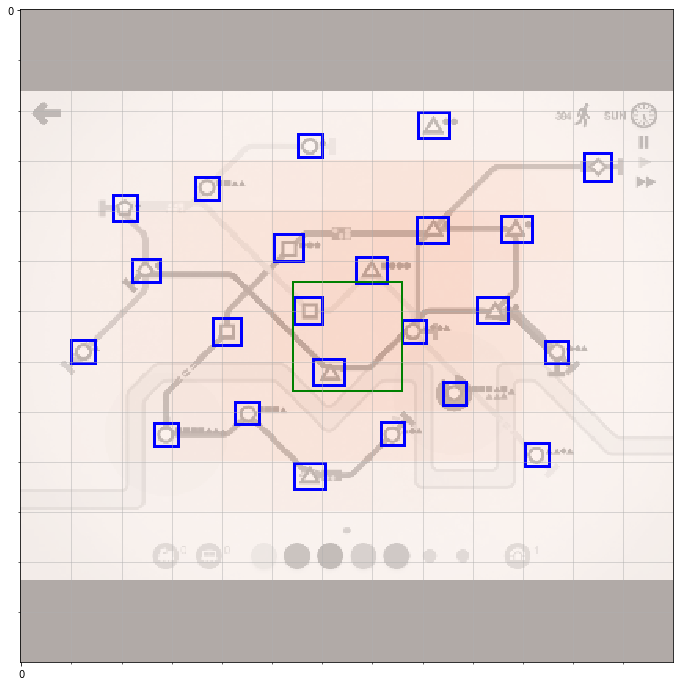

(80, 80)


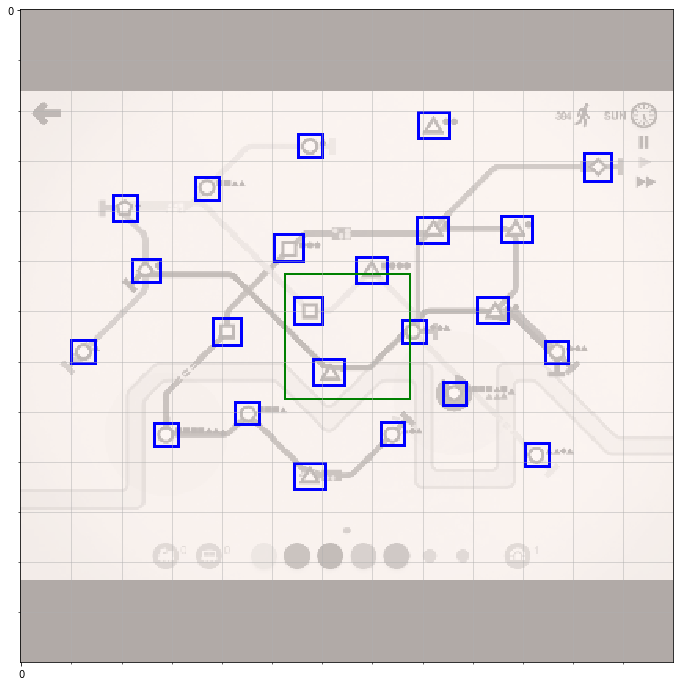

(90, 90)


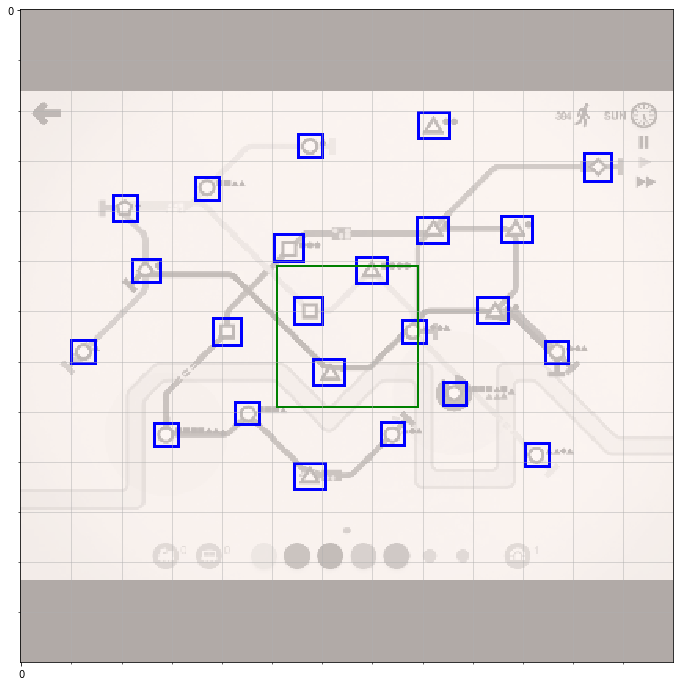

YOLOLayer(
  (mse_loss): MSELoss()
  (bce_loss): BCELoss()
)
torch.Size([3, 26, 26])
(40, 40)


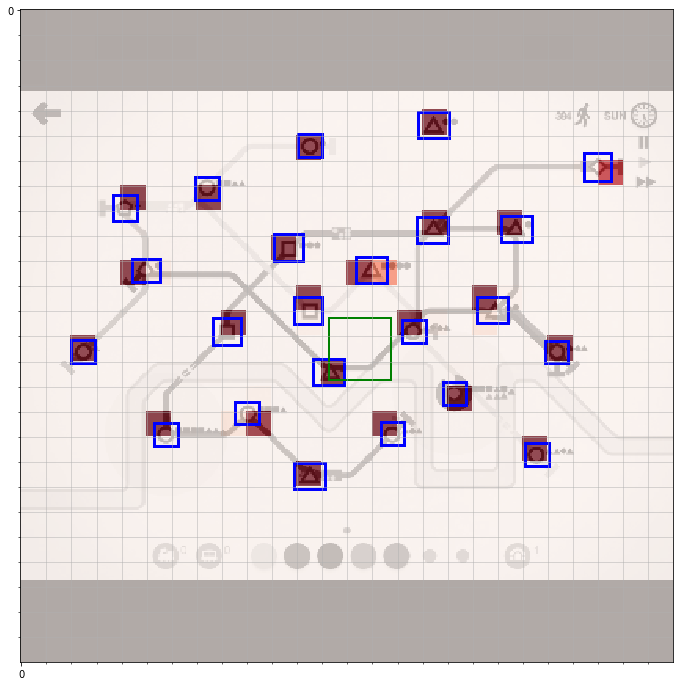

(50, 50)


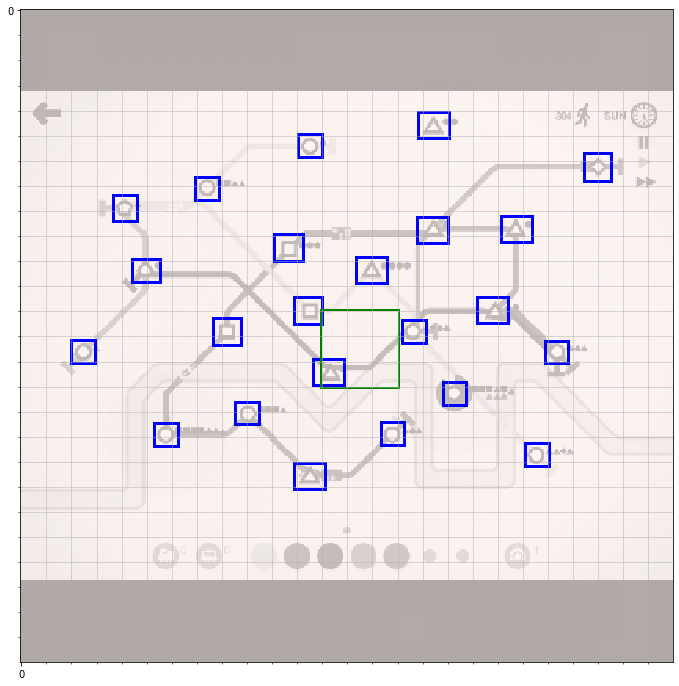

(60, 60)


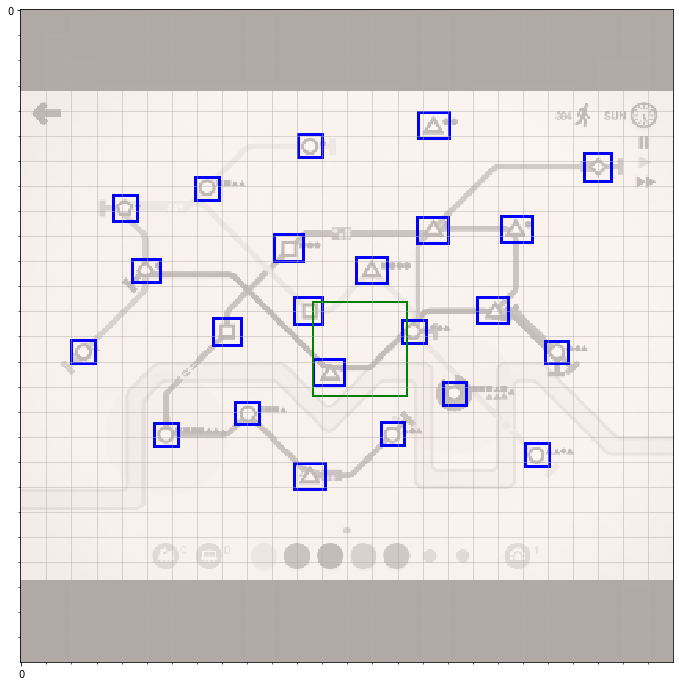

YOLOLayer(
  (mse_loss): MSELoss()
  (bce_loss): BCELoss()
)
torch.Size([3, 52, 52])
(10, 10)


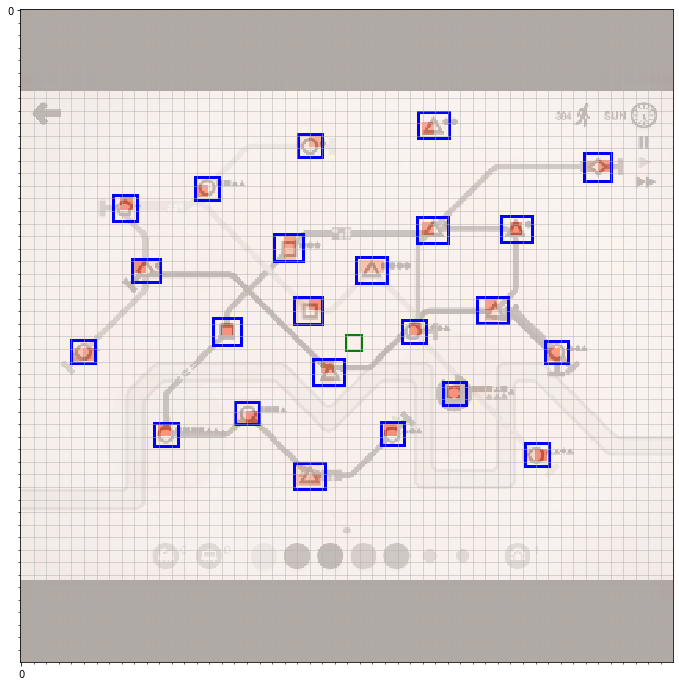

(20, 20)


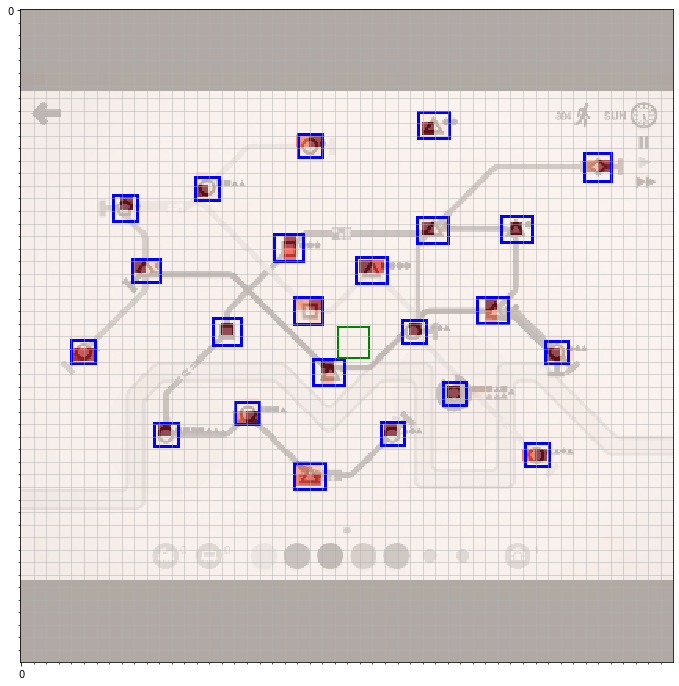

(30, 30)


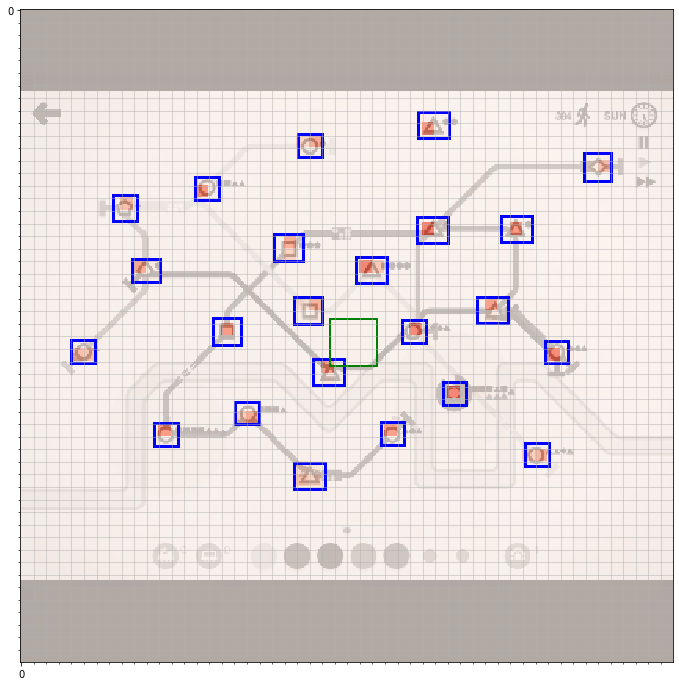

In [408]:
# updating layer_dict
station_detector.predict(images[0], conf_threshold, nms_threshold)

Path('tmp.txt').write_text(str(img_paths[0]))

dataset = ListDataset('tmp.txt', img_size=img_size, augment=False, multiscale=False)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, collate_fn=dataset.collate_fn)

img_path, test_image, test_targets = next(iter(dataloader))

test_image_array = test_image.squeeze().permute(1,2,0).numpy()

for layer in output_layers:
    print(layer)
    
    l_i, l_o = layer_dict[layer]
    
    object_conf_activations = l_i[0].squeeze()[(4,10,16), ...]
    probs = torch.sigmoid(object_conf_activations)
    print(probs.shape)
    for anchor, detector_probs in zip(layer.anchors, probs):
        print(anchor)
        
        fig = annotate_image(
            test_image_array,
            test_targets,
            anchor_wh=anchor,
            object_conf_grid=detector_probs,
            grid_size=layer.grid_size
        );
        plt.show();